# Масликов Дмитрий БПМ191

In [2]:
import numpy as np
from numba import njit, cfunc, prange
import matplotlib.pyplot as plt
from time import time
from tqdm import trange

### 0.

In [3]:
jkw = dict(cache=True)

mu2 = 3.001348389698916e-6
mu1 = 1 - mu2
mc = np.array([mu2])


@cfunc('f8[:](f8, f8[:], f8[:])', **jkw)
def crtbp_ode(t, s, mc):
    '''
    Правая часть СДУ, которая описывает движение невесомого тела
    в системе из двух массивных тел, вращающихся относительно общего 
    центра масс.
    
    Parameters
    ----------
    t: int
        Момент времени
    s: array_like
        Состояние системы
    mc: array_like
        Константы системы
        
    Returns
    -------
    array_like
        Массив, состоящий из скоростей и ускорений
    '''
    x, y, z, vx, vy, vz = s
    mu2 = mc[0]
    mu1 = 1 - mu2
    
    r1 = ((x + mu2)**2 + y**2 + z**2)**(-1.5)
    r2 = ((x - mu1)**2 + y**2 + z**2)**(-1.5)
    c = mu1 * r1 + mu2 * r2
    
    ax = 2 * vy + x - (mu1 * (x + mu2) * r1 + mu2 * (x - mu1) * r2)
    ay = -2 * vx + y - c * y
    az = - c * z
    
    return np.array([vx, vy, vz, ax, ay, az])

### 1. Реализация обобщённого метода Рунге-Кутты

In [4]:
@njit(**jkw)
def rk_butcher_step(f, t, s, h, A, b, c, mc):
    '''
    Функция выполняет расчёт одного шага размера h 
    для метода Рунге-Кутты на основе таблицы Бутчера.
    
    Parameters
    ----------
    f: function
        Правая часть СДУ
    t: int
        Момент времени
    s: array_like 1D
        Состояние системы
    h: float
        Шаг dt
    A: array_like 2D
        Матрица коэффициентов "a" таблицы Бутчера
    b: array_like 1D
        Массив коэффициентов "b" таблицы Бутчера
    c: array_like 1D
        Массив коэффициентов "c" таблицы Бутчера
    mc: array_like
        Массив констант модели
    
    Returns
    -------
    array_like
        Итог расчёта одного шага размера h.
    '''
    
    dim = b.shape[0]
    k = np.zeros((dim, s.shape[0]))
    k[0] = f(t, s, mc)
    for i in range(1, dim):
        k[i] = f(t + c[i] * h, s + (A[i, :i] @ k[:i]) * h, mc)
    return s + h * (b @ k)


@njit(**jkw)
def rk_butcher_nsteps(f, t, s, h, A, b, c, mc, n):
    '''
    Функция выполняет расчёт n шагов размера h 
    для метода Рунге-Кутты на основе таблицы Бутчера.
    
    Parameters
    ----------
    f: function
        Правая часть СДУ
    t: int
        Момент времени
    s: array_like 1D
        Состояние системы
    h: float
        Шаг dt
    A: array_like 2D
        Матрица коэффициентов "a" таблицы Бутчера
    b: array_like 1D
        Массив коэффициентов "b" таблицы Бутчера
    c: array_like 1D
        Массив коэффициентов "c" таблицы Бутчера
    mc: array_like
        Массив констант модели
    n: int
        Количество шагов размера h
    
    Returns
    -------
    array_like
        Итог расчёта для n шагов.
    '''
    arr = np.empty((n + 1, s.shape[0] + 1))
    arr[:, 0] = t + h * np.arange(n + 1)
    arr[0, 1:] = s
    
    for i in range(n):
        arr[i + 1, 1:] = rk_butcher_step(f,
                                         arr[i, 0],
                                         arr[i, 1:],
                                         h,
                                         A,
                                         b,
                                         c,
                                         mc)
    return arr

#### Таблица Бутчера для интегратора 5 порядка (Fehlberg's RK56):

In [5]:
A = np.array([[0, 0, 0, 0, 0, 0],
              [1/4, 0, 0, 0, 0, 0],
              [3/32, 9/32, 0, 0, 0, 0],
              [1932/2197, -7200/2197, 7296/2197, 0, 0, 0],
              [439/216, -8, 3680/513, -845/4104, 0, 0],
              [-8/27, 2, -3544/2565, 1859/4104, -11/40, 0]])
c = np.array([0, 1/4, 3/8, 12/13, 1, 1/2])
b = np.array([16/135, 0, 6656/12825, 28561/56430, -9/50, 2/55])

### 2. Алгортим вычисления начальной скорости для неустойчивой орбиты вокргу L1

Модификация функции rk_butcher_nsteps для досрочной остановки интегрирования приусловии пересечения одной из плоскостей:

In [6]:
@njit(**jkw)
def rk_butcher_nsteps_planes(f, t, s, h, A, b, c, mc, n, pl):
    '''
    Функция выполняет расчёт n шагов размера h 
    для метода Рунге-Кутты на основе таблицы Бутчера.
    
    Parameters
    ----------
    f: function
        Правая часть СДУ
    t: int
        Момент времени
    s: array_like 1D
        Состояние системы
    h: float
        Шаг dt
    A: array_like 2D
        Матрица коэффициентов "a" таблицы Бутчера
    b: array_like 1D
        Массив коэффициентов "b" таблицы Бутчера
    c: array_like 1D
        Массив коэффициентов "c" таблицы Бутчера
    mc: array_like
        Массив констант модели
    n: int
        Количество шагов размера h
    pl: array_like
        Массив с граничными координатами xmin и xmax
        
    Returns
    -------
    array_like
        Итог расчёта - результирующий массив состояний.
    '''
    arr = np.empty((n + 1, s.shape[0] + 1))
    arr[:, 0] = t + h * np.arange(n + 1)
    arr[0, 1:] = s
    
    for i in range(n):
        arr[i + 1, 1:] = rk_butcher_step(f,
                                         arr[i, 0],
                                         arr[i, 1:],
                                         h,
                                         A,
                                         b,
                                         c,
                                         mc)
        x = arr[i + 1, 1]
        if x < pl[0] or x > pl[1]:
            break
            
    return arr[:i + 2]

Найдём точку L1 и её координату x:

In [7]:
def g(x, mc):
    s = np.zeros(6)
    s[0] = x
    return crtbp_ode(0., s, mc)[3]  # возвращаем ax

In [8]:
from scipy.optimize import root

x0  = 3 / 4 * mu1
xL1 = root(g, x0, mc, tol=1e-12).x[0]
xL1

0.9900289479871318

In [9]:
R = 149600000
(mu1 - xL1) * R # Рассотяние от L1 до земли

1491220.3794059805

Функция для расчета начальной скорости $𝑣𝑦_0$ на основе метода бисекции для орбиты, заданной начальным положением $(𝑥_0,0,𝑧_0)$  и условием ортогональности вектора скорости и плоскости $𝑋𝑂𝑍$ в начальный момент времени.

Сначала небольшие выкладки с семинара. Сама функция реализована ниже.

In [10]:
d = (mu1 - xL1) * 0.99
pmin = xL1 - d
pmax = xL1 + d
h = 0.001721420632103996  # 1/10 суток
pl = np.array([pmin, pmax])

In [11]:
s0 = np.zeros(6)
s0[[0, 2, 4]] = xL1 + d * 0.1, d * 0.1, 0.02

arr0 = rk_butcher_nsteps(crtbp_ode, 0., s0, h, A, b, c, mc, 700)

s0 = np.zeros(6)
s0[[0, 2, 4]] = xL1 + d * 0.1, d * 0.1, -0.02

arr1 = rk_butcher_nsteps(crtbp_ode, 0., s0, h, A, b, c, mc, 700)

Text(0, 0.5, 'y, nd')

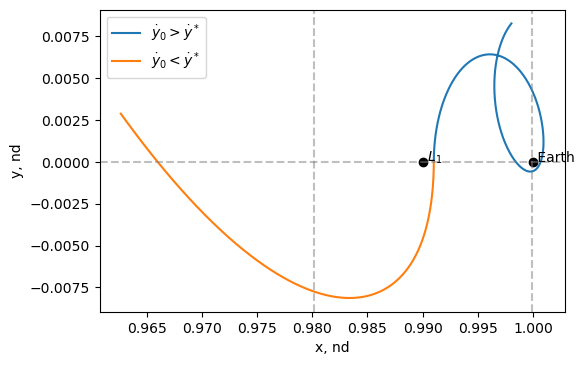

In [12]:
# График на плоскости XOY

plt.figure(dpi=100)

# траектории
plt.plot(arr0[:, 1], arr0[:, 2], label='$\dot{y}_0 > \dot{y}^*$')
plt.plot(arr1[:, 1], arr1[:, 2], label='$\dot{y}_0 < \dot{y}^*$')

# точка L1
plt.plot(xL1, 0., 'ok')
plt.text(xL1, 0., ' $L_1$')

# Земля
plt.plot(mu1, 0., 'ok')
plt.text(mu1, 0., ' Earth')

# Плоскости
plt.axvline(pmin, ls='--', color='gray', alpha=0.5)
plt.axvline(pmax, ls='--', color='gray', alpha=0.5)

# Ось OX
plt.axhline(0., ls='--', color='gray', alpha=0.5)

plt.legend()

plt.xlabel('x, nd')
plt.ylabel('y, nd')

Проверим работоспособность модификации функции с досрочной остановкой при условии пересечения одной из плоскостей:

In [13]:
s0 = np.zeros(6)
s0[[0, 2, 4]] = xL1 + d * 0.1, d * 0.1, 0.02

arr0 = rk_butcher_nsteps_planes(crtbp_ode, 0., s0, h, A, b, c, mc, 500, pl)

s0 = np.zeros(6)
s0[[0, 2, 4]] = xL1 + d * 0.1, d * 0.1, -0.02

arr1 = rk_butcher_nsteps_planes(crtbp_ode, 0., s0, h, A, b, c, mc, 500, pl)

Text(0, 0.5, 'y, nd')

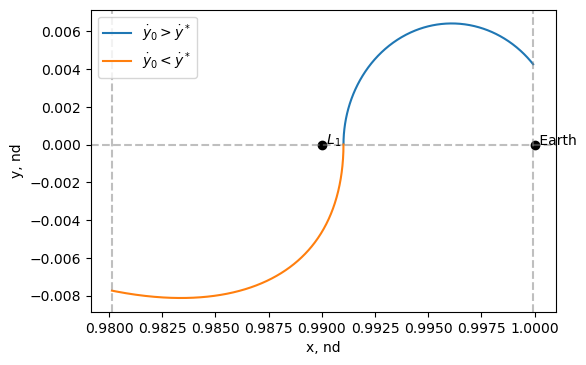

In [14]:
# График на плоскости XOY

plt.figure(dpi=100)

# траектории
plt.plot(arr0[:, 1], arr0[:, 2], label='$\dot{y}_0 > \dot{y}^*$')
plt.plot(arr1[:, 1], arr1[:, 2], label='$\dot{y}_0 < \dot{y}^*$')

# точка L1
plt.plot(xL1, 0., 'ok')
plt.text(xL1, 0., ' $L_1$')

# Земля
plt.plot(mu1, 0., 'ok')
plt.text(mu1, 0., ' Earth')

# Плоскости
plt.axvline(pmin, ls='--', color='gray', alpha=0.5)
plt.axvline(pmax, ls='--', color='gray', alpha=0.5)

# Ось OX
plt.axhline(0., ls='--', color='gray', alpha=0.5)

plt.legend()

plt.xlabel('x, nd')
plt.ylabel('y, nd')

#### Непосредственно реализация функции расчёта начальной скорости $vy_0$:

In [15]:
@njit(**jkw)
def get_plane(vy, f, s, h, A, b, c, mc, n, pl):
    '''
    Функция показывает, какую плоскость пересекли: с координатой xmin или xmax
    
    Parameters
    ----------
    vy: float
        Начальная скорость
    f: function
        Правая часть СДУ
    s: array_like 1D
        Состояние системы
    h: float
        Шаг dt
    A: array_like 2D
        Матрица коэффициентов "a" таблицы Бутчера
    b: array_like 1D
        Массив коэффициентов "b" таблицы Бутчера
    c: array_like 1D
        Массив коэффициентов "c" таблицы Бутчера
    mc: array_like
        Массив констант модели
    n: int
        Количество шагов размера h
    pl: array_like
        Массив с граничными координатами xmin и xmax
        
    Returns
    -------
    int
        -1, если пересекли левую плоскость, или 1, если правую
    '''
    
    s0 = s.copy()
    s0[4] = vy
    arr = rk_butcher_nsteps_planes(f, 0., s0, h, A, b, c, mc, n, pl)
    x = arr[-1, 1]
    xmean = np.mean(pl)
    return -1 if x < xmean else 1


@njit(**jkw)
def bisect_for_numba(f, ymin, ymax, s, h, A, b, c, mc, n, pl, xtol=1e-16):
    '''
    Реализация метода бисекции с той целью, чтобы она работала с модулем numba.
    
    Parameters
    ----------
    f: function
        Правая часть СДУ
    ymin: float
        Левая граница отрезка
    ymax: float
        Правая граница отрезка
    s: array_like 1D
        Состояние системы
    h: float
        Шаг dt
    A: array_like 2D
        Матрица коэффициентов "a" таблицы Бутчера
    b: array_like 1D
        Массив коэффициентов "b" таблицы Бутчера
    c: array_like 1D
        Массив коэффициентов "c" таблицы Бутчера
    mc: array_like
        Массив констант модели
    n: int
        Количество шагов размера h
    pl: array_like
        Массив с граничными координатами xmin и xmax
    xtol: float
        Абсолютная точность
        
    Returns
    -------
    float
        Искомое значение.
    '''
    
    v1 = get_plane(ymin, f, s, h, A, b, c, mc, n, pl)
    v2 = get_plane(ymax, f, s, h, A, b, c, mc, n, pl)
    if v1 * v2 > 0:  # Если они одинаковых знаков
        return bisect_for_numba(f, 
                                ymin - abs(ymin) * 0.2, 
                                ymax + abs(ymax) * 0.2,
                                s, h,
                                A, b, c,
                                mc, n, pl
                               )
    else:
        for _ in range(100):
            mid = (ymin + ymax) / 2
            buf = get_plane(mid, f, s, h, A, b, c, mc, n, pl)
            if abs(mid - ymax) < xtol:
                return mid
            if v1*buf > 0:
                ymin = mid
            else:
                ymax = mid


@njit(**jkw)
def v_start(f, ymin, ymax, x0, z0, h, A, b, c, mc, n, pl, xtol=1e-16):
    '''
    Parameters
    ----------
    f: function
        Правая часть СДУ
    ymin: float
        Левая граница отрезка
    ymax: float
        Правая граница отрезка
    x0: float
        Начальное значение x
    z0: float
        Начальное значение z
    h: float
        Шаг dt
    A: array_like 2D
        Матрица коэффициентов "a" таблицы Бутчера
    b: array_like 1D
        Массив коэффициентов "b" таблицы Бутчера
    c: array_like 1D
        Массив коэффициентов "c" таблицы Бутчера
    mc: array_like
        Массив констант модели
    n: int
        Количество шагов размера h
    pl: array_like
        Массив с граничными координатами xmin и xmax
    xtol: float
        Абсолютная точность

    Returns
    -------
    v: float
        Искомая начальная скорость.
    '''
    
    s0 = np.zeros(6)
    s0[0] = x0
    s0[2] = z0

    v = bisect_for_numba(f, ymin, ymax, s0, h, A, b, c, mc, n, pl, xtol)
    return v

### 3. Алгортим вычисления начальных скоростей орбит, начальные состояния которых заданы на решётке

In [16]:
@njit(**jkw, parallel=True)
def v_start_grid(N, f, ymin, ymax, xmin, xmax, zmin, zmax, h, A, b, c, mc, n, pl, xtol=1e-16):
    '''
    Parameters
    ----------
    N: int
        Задаёт размеры квадратной решетки.
    f: function
        Правая часть СДУ
    ymin: float
        Левая граница отрезка
    ymax: float
        Правая граница отрезка
    xmin: float 
        координата плоскости x=xmin
    xmax: float
        координата плоскости x=xmax
    zmin: float
        координата плоскости z=zmin
    zmax: float
        координата плоскости z=zmax
    h: float
        Шаг dt
    A: array_like 2D
        Матрица коэффициентов "a" таблицы Бутчера
    b: array_like 1D
        Массив коэффициентов "b" таблицы Бутчера
    c: array_like 1D
        Массив коэффициентов "c" таблицы Бутчера
    mc: array_like
        Массив констант модели
    n: int
        Количество шагов размера h
    pl: array_like
        Массив с граничными координатами xmin и xmax
    xtol: float
        Абсолютная точность

    Returns
    -------
    v: array_like (N, N)
        Искомая матрица начальных скоростей
    '''
    
#     x = np.arange(xmin, xmax, (xmax - xmin) / N)
#     z = np.arange(zmin, zmax, (zmax - zmin) / N)
    x = np.linspace(xmin, xmax, N)
    z = np.linspace(zmin, zmax, N)
    v = np.zeros((N, N))
    for i in prange (N):
        for j in range (N):
            v[j, i] = v_start(f, ymin, ymax, x[i], z[j], h, A, b, c, mc, n, pl, xtol)
    return v

### 4-7. Использование модуля numba. Вычисления начальных скоростей и констант Якоби на заданных решетках. Измерение времени вычислений. Сохранение результатов в файлах *.npy.

In [17]:
R = 149600000
dg = 1000000 / R
xmin = xL1 - dg / 2
xmax = xL1 + dg / 2
zmin = 0.
zmax = dg

Ниже для каждой сетки выводится время вычислений (в секундах):

Вычисления для сетки $40\times 40$. 
Время расчётов: примерно 6 минут.

In [36]:
N = 40
cur_time = time()
v_matrix = v_start_grid(N, crtbp_ode, -0.1, 0.1, xmin, xmax, zmin, zmax, h, A, b, c, mc, 5000, pl, 1e-12)
print(time() - cur_time)

596.2241067886353


In [37]:
np.save("v_matrix_N_"+str(N)+".npy", v_matrix)

Вычисления для сетки $80\times 80$. Время расчётов: примерно 40 минут.

In [30]:
N = 80
cur_time = time()
v_matrix = v_start_grid(N, crtbp_ode, -0.1, 0.1, xmin, xmax, zmin, zmax, h, A, b, c, mc, 5000, pl, 1e-12)
print(time() - cur_time)

2388.3017151355743


In [32]:
np.save("v_matrix_N_"+str(N)+".npy", v_matrix)

Вычисления для сетки $160\times 160$. Время расчётов: примерно 1 час 55 минут.

In [24]:
N = 160
cur_time = time()
v_matrix = v_start_grid(N, crtbp_ode, -0.1, 0.1, xmin, xmax, zmin, zmax, h, A, b, c, mc, 5000, pl, 1e-10)
print(time() - cur_time)

6928.868640899658


In [26]:
np.save("v_matrix_N_"+str(N)+".npy", v_matrix)

Вычисления для сетки $320\times 320$. Время расчётов: примерно 7 часов 40 минут.

In [33]:
N = 320
cur_time = time()
v_matrix = v_start_grid(N, crtbp_ode, -0.1, 0.1, xmin, xmax, zmin, zmax, h, A, b, c, mc, 5000, pl, 1e-10)
print(time() - cur_time)

27560.586450099945


In [35]:
np.save("v_matrix_N_"+str(N)+".npy", v_matrix)

Вычисление констант Якоби на заданных решетках и сохранение результатов в файлах *.npy.

In [64]:
for N in [40, 80, 160, 320]:
    v_matrix = np.load("v_matrix_N_"+str(N)+".npy")
    x = np.linspace(xmin, xmax, N)
    z = np.linspace(zmin, zmax, N)
    U = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            r1 = ((x[i] + mu2)**2 + z[j]**2)**0.5
            r2 = ((x[i] - 1 + mu2)**2 + z[j]**2)**0.5
            U[i, j] = 2* (x[i]**2 / 2 + (1 - mu2) / r1 + mu2 / r2) - v_matrix[j,i]**2
    np.save("Jacobi_constant_N_"+str(N)+".npy", U)

### 8. Строим цветовые карты рассчитанных величин

Цветовые карты для начальных скоростей:

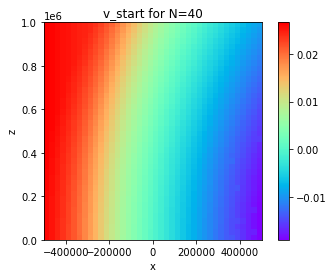

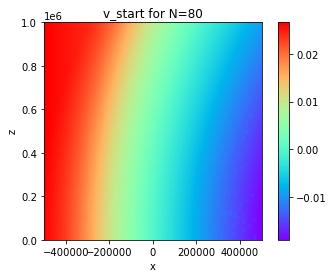

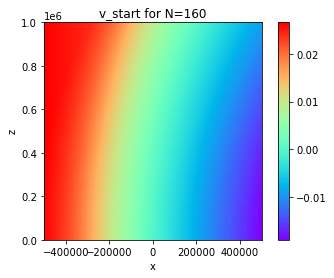

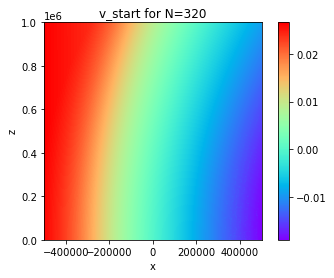

In [73]:
for N in [40, 80, 160, 320]:
    v_matrix = np.load("v_matrix_N_"+str(N)+".npy")
    plt.imshow(np.rot90(v_matrix.T),extent=[(xmin - xL1)*R,(xmax-xL1)*R, zmin*R, zmax*R], cmap='rainbow')
    plt.colorbar()
    plt.xlabel("x")
    plt.ylabel("z")
    plt.title(f"v_start for N={N}")
    plt.show()

Цветовые карты для Констант Якоби:

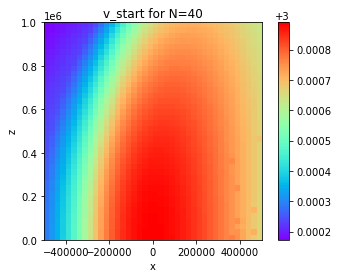

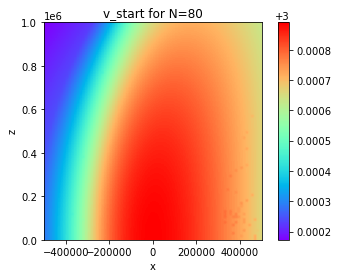

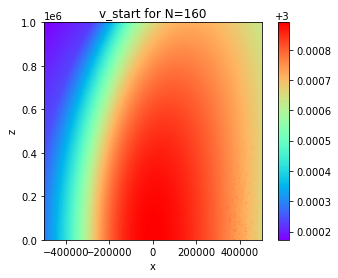

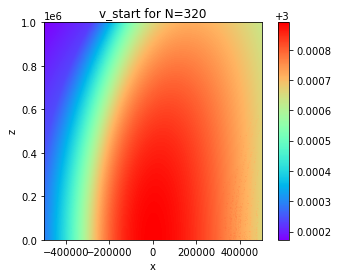

In [75]:
for N in [40, 80, 160, 320]:
    Jacobi_matrix = np.load("Jacobi_constant_N_"+str(N)+".npy")
    plt.imshow(np.rot90(Jacobi_matrix),extent=[(xmin - xL1)*R,(xmax-xL1)*R, zmin*R, zmax*R], cmap='rainbow')
    plt.colorbar()
    plt.xlabel("x")
    plt.ylabel("z")
    plt.title(f"v_start for N={N}")
    plt.show()